# ThreeBody

The ThreeBody problem from Hairer is a standard test of non-stiff methods. We have a lot of non-stiff methods, so let's see how they fair against eachother.

In [36]:
using DifferentialEquations

## Define the ThreeBody Problem
const threebody_μ = parse(BigFloat,"0.012277471"); const threebody_μ′ = 1 - threebody_μ

f = (t,u,du) -> begin
  # 1 = y₁
  # 2 = y₂
  # 3 = y₁'
  # 4 = y₂'
  D₁ = ((u[1]+threebody_μ)^2 + u[2]^2)^(3/2)
  D₂ = ((u[1]-threebody_μ′)^2 + u[2]^2)^(3/2)
  du[1] = u[3]
  du[2] = u[4]
  du[3] = u[1] + 2u[4] - threebody_μ′*(u[1]+threebody_μ)/D₁ - threebody_μ*(u[1]-threebody_μ′)/D₂
  du[4] = u[2] - 2u[3] - threebody_μ′*u[2]/D₁ - threebody_μ*u[2]/D₂
end

prob_ode_threebody = ODEProblem(f,[0.994, 0.0, 0.0, parse(BigFloat,"-2.00158510637908252240537862224")])

t₀ = 0.0; T = parse(BigFloat,"17.0652165601579625588917206249")

tspan = [t₀,T]
tspan2 = [t₀,2T]
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:dopri5)
          Dict(:alg=>:ode45)
          Dict(:alg=>:ode45,:norm=>(y)->vecnorm(y,2))
          Dict(:alg=>:ExplicitRK)
          Dict(:alg=>:BS5)
          Dict(:alg=>:Tsit5)
          Dict(:alg=>:Vern8,:β=>0.08)
          #Dict(:alg=>:ode78,:minstep=>1e-15)
          Dict(:alg=>:DP8)
          Dict(:alg=>:dop853)
          ];
names = ["DP5","dopri5","ode45","ode45n2","ExplicitRK","BS5","Tsit5","Vern8",#"ode78",
         "DP8","dop853"];

Now we're ready. When solved on this timespan the problem is periodic. So we can pass `ode_shootout` the final answer as the initial condition in order to have it calculate errors even though the analytical solution is not known.

Names: String["DP5","dopri5","ode45","ode45n2","ExplicitRK","BS5","Tsit5","Vern8","DP8","dop853"], Winner: Vern8
Efficiencies: [34.7637,7.42867,16.8302,18.7308,18.8161,14.4694,12.0576,1555.7,190.951,120.816]
EffRatios: [44.7507,209.419,92.4349,83.0557,82.6795,107.517,129.023,1.0,8.14712,12.8766]
Times: [0.0636449,0.0700567,0.0540399,0.0513048,0.0376069,0.0357129,0.0404171,0.0811129,0.0973524,0.0351504]
Errors: [0.451971,1.9215,1.0995,1.0406,1.4132,1.93519,2.05199,0.00792471,0.0537937,0.235475]




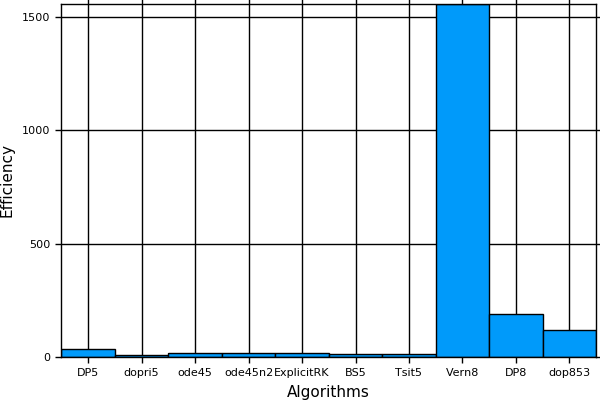

In [37]:
shoot = ode_shootout(prob_ode_threebody,tspan,setups,endsol=prob_ode_threebody.u₀,abstol=1e-6,reltol=1e-3,names=names)
println(shoot)
plot(shoot)

This shows that `:Vern8` is by far the most efficient algorithm in this lineup, getting about the same runtime as `:DP5` and `:dopri5` while achiving 100x less error. Here `:dop853` also has a strong showing over the 5th order methods, matching what Hairer has seen. Notice here that `:DP5` has a strong showing, taking less time than `:dopri5` while also achieving almost 10x less error. 

Notice that ODE.jl's `:ode45` actually performs better than `:dopri5`. That is really odd an unexpected. When examining the source code, I was able to reveal that the major difference was the choice of norm. Where as DifferentialEquations.jl and ODEInterface (the Hairer algorithms) use an L2-based norm as the defult, ODE.jl uses an L∞ norm. 

Note that `:ode78` was not in this test since it failed (minimum timestep reached, when when changed to 1e-15). Essentially, it took too large steps, got off-course, and couldn't recover.

### Lower Tolerances

Now let's try it at lower tolerances.

Names: String["DP5","dopri5","ode45","ode45n2","ExplicitRK","BS5","Tsit5","Vern8","DP8","dop853"], Winner: Vern8
Efficiencies: [5053.2,93.5381,112.802,132.875,279.367,282.053,129.166,1.08843e6,55490.8,334.601]
EffRatios: [215.395,11636.3,9649.05,8191.39,3896.06,3858.96,8426.63,1.0,19.6147,3252.93]
Times: [0.138136,0.0486776,0.0892961,0.0929956,0.088316,0.0816871,0.0893572,0.141842,0.168747,0.0523641]
Errors: [0.00143261,0.219626,0.0992774,0.0809271,0.0405308,0.0434026,0.0866408,6.47731e-6,0.000106793,0.0570741]




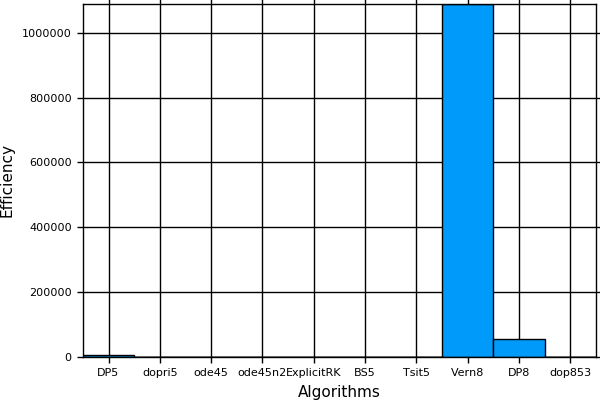

In [33]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:dopri5)
          Dict(:alg=>:ode45)
          Dict(:alg=>:ode45,:norm=>(y)->vecnorm(y,2))
          Dict(:alg=>:ExplicitRK)
          Dict(:alg=>:BS5)
          Dict(:alg=>:Tsit5)
          Dict(:alg=>:Vern8,:β=>0.08)
          #Dict(:alg=>:ode78,:minstep=>1e-15)
          Dict(:alg=>:DP8)
          Dict(:alg=>:dop853)
          ];
names = ["DP5","dopri5","ode45","ode45n2","ExplicitRK","BS5","Tsit5","Vern8",#"ode78",
         "DP8","dop853"];

shoot = ode_shootout(prob_ode_threebody,tspan,setups,endsol=prob_ode_threebody.u₀,abstol=1e-9,reltol=1e-5,names=names)
println(shoot)
plot(shoot)

`:DP5` takes alightly longer but dramatically reduces the error. Here, `:DP8` comes in second with timings closer to `:ode45` and  `:dop853` but greatly reduced error. Once again, the Hairer algorithms are really fast, at the cost of having more error. But the `Vern8` algorithm runs faster than `:DP8` with less error.

### Double Timespan

Now let's see what happens if we double the timespan:

Names: String["DP5","dopri5","ode45","ode45n2","Vern8","DP8","dop853"], Winner: Vern8
Efficiencies: [31.5617,6.45371,3.60307,3.5313,192.074,173.937,6.55725]
EffRatios: [6.08568,29.7618,53.3085,54.3919,1.0,1.10428,29.2919]
Times: [0.267176,0.0853759,0.1589,0.164734,0.371658,0.334621,0.0907738]
Errors: [0.118589,1.81491,1.74664,1.71902,0.0140084,0.0171813,1.68003]




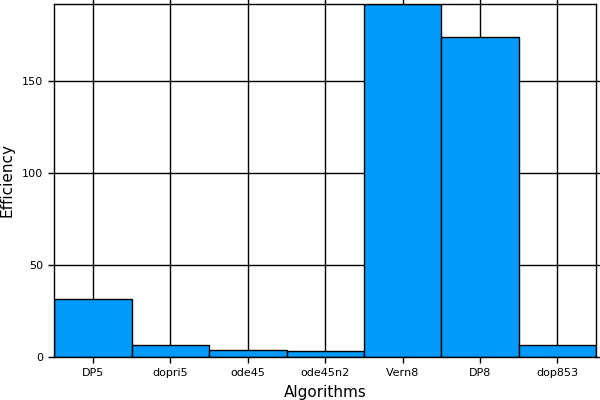

In [24]:
tspan2 = [t₀,2T]
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:dopri5)
          Dict(:alg=>:ode45)
          Dict(:alg=>:ode45,:norm=>(y)->vecnorm(y,2))
          Dict(:alg=>:Vern8,:β=>0.1)
          #Dict(:alg=>:ode78,:minstep=>1e-15)
          Dict(:alg=>:DP8,:β=>0.1)
          Dict(:alg=>:dop853)
          ];
names = ["DP5","dopri5","ode45","ode45n2","Vern8",#"ode78",
         "DP8","dop853"];

shoot = ode_shootout(prob_ode_threebody,tspan2,setups,endsol=prob_ode_threebody.u₀,abstol=1e-9,reltol=1e-5,names=names)
println(shoot)
plot(shoot)

In this case `:DP5` clearly dominates but takes more time. `:DP8` takes close to `:ode45` but does so with 50x less error. The Hairer algorithms run fast with large errors. But this `Vern8` algorithm is really something: still not very optimized, but easily showing good results.

### Other Methods

Lastly, we will compare these Runge-Kutta methods to Hairer's extrapolation and Sundial's Adams-Moulton method. 

Names: String["DP5","dopri5","DP8","dop853","Vern6","Vern7","odex","cvode_Adams"], Winner: Vern6
Efficiencies: [33.9496,7.48405,186.589,122.339,4600.81,338.088,18.2417,30.2433]
EffRatios: [135.519,614.749,24.6575,37.6072,1.0,13.6083,252.214,152.127]
Times: [0.0651711,0.0695383,0.0996284,0.034713,0.0846843,0.0805004,0.0256384,0.0155264]
Errors: [0.451971,1.9215,0.0537937,0.235475,0.00256663,0.0367427,2.13818,2.12961]




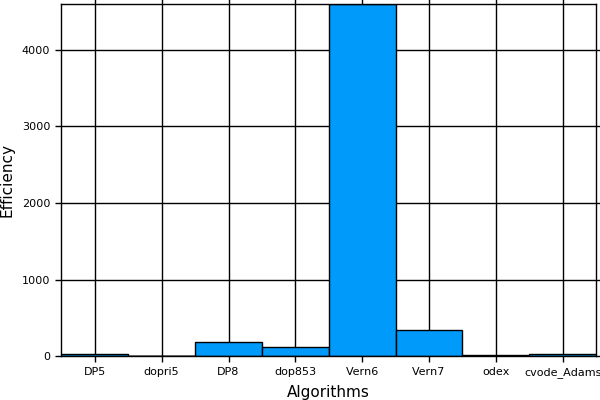

In [44]:
tspan = [t₀,T]
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:dopri5)
          Dict(:alg=>:DP8)
          Dict(:alg=>:dop853)
          Dict(:alg=>:Vern6,:β=>.1)
          Dict(:alg=>:Vern7,:β=>.08)
          Dict(:alg=>:odex)
          Dict(:alg=>:cvode_Adams)
          ];
shoot = ode_shootout(prob_ode_threebody,tspan,setups,endsol=prob_ode_threebody.u₀,abstol=1e-6,reltol=1e-3)
println(shoot)
plot(shoot)

As Hairer and Shampine noted before, extrapolation and Adams-based methods are simply not as efficient as Runge-Kutta methods in this domain (medium error tolerance, cheap function calculations). The Verner methods continue to have a strong showing, though their default PI parameters need to be tweaked.

### Conclusion

For the threebody problem, DifferentialEquations.jl has a strong showing. Its algorithms tend to produce very accurate answers with comparable runtimes. Unlike the linear benchmarks, here the 8th-order algorithms had a time to shine. The ODEInterface `:dop853` algorithms had its own advantage over the DifferentialEquations.jl algorithms in that, for the cost of a lot more error, they were the fastest algorithms (until taking into acccount extrapolation and Adams methods which had an unbearable amount of error in comparison). 

This is a good time to explain what the difference is. The `:DP8` algorithm is based on the same Dormand-Prince 3/5/8 triple as `:dop853` but implements the error correction differently. It uses the same pooled Order 3 / Order 5 estimate as `:dop853`, but `:dop853` uses the L2-seminorm which modifies by the vector size while `:DP8` by default does not (switch via `fullnormalize=true`). This an some slight differences to the PI-control make `:DP8` more efficient, while `:dop863` is tuned for faster runtime (at but increases the error faster than the runtime falls). Thus these algorithms, being slightly different, can have different uses in different cases. However, ODE.jl did not have a good showing. Its `:ode78` simply errored on the tests, while `:ode45` could not hold up to the other methods. This is inline with the linear test results, indicating a trend that ODE.jl is not as efficient as other libraries.

Note that these results also are for the standard `:Vern8` method. The multithreaded `:Vern8` method will likely be much more efficient. Since all of the Verner methods have order-matching continuous output (which was not disabled in these tests), this means that they are featured filled and good contenders for being "go-to" methods. Still, a lot more optimizations need to be done.

The tolerances we looked at are not low enough for the Feagin methods to matter. 